In [243]:
import pandas as pd
import sqlite3
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

import time

import geopandas as gpd
import pandas as pd
import pyproj

import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as cl
from matplotlib import collections  as mc
from matplotlib.colors import LinearSegmentedColormap

import locale
locale.setlocale(locale.LC_ALL, 'es_ES')


def get_files_in_folder(folder, filetype):
    files = []
    for f in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, f)) and f.lower().endswith(filetype.lower()):
            files.append(os.path.join(folder, f))
    return files


def cartesian(radius, theta):
    theta = math.radians(theta)
    x = radius * math.cos(theta)
    y = radius * math.sin(theta)
    return x,y

def rgb(rgb):
    # Given a tuple in the range 0-255, returns a color in 0-1 range
    return (rgb[0]/255, rgb[1]/255, rgb[2]/255)

def hex_color(rgb):
    return '#%02x%02x%02x' % rgb


import numpy as np
def anomalies(data, deviation):
    '''
    Devuelve el indice y el valor de las anomalias
    siguiendo la tecnica de la desviacion tipica
    '''
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cutoff = data_std * deviation
    lower_limit = data_mean - anomaly_cutoff
    upper_limit = data_mean + anomaly_cutoff
    anomalies = [True if (val > upper_limit) | (val < lower_limit) else False for i,val in enumerate(data)]
    return anomalies


def interpolate(d, x):
    # data = [[2019, 12124],[2021, 5700]]
    # x = 2020
    output = d[0][1] + (x - d[0][0]) * ((d[1][1] - d[0][1])/(d[1][0] - d[0][0])) 
    return output


def distance(x0,y0,x1,y1):
    return math.sqrt((x0-x1)**2+(y0-y1)**2)


def numeric_text(t):
    return locale.format_string('%.f', t, grouping=True, monetary=False)


WHITE = (255,255,255)
BLACK = (0,0,0)
BEIGE = (224,218,213)
RED = (165,42,42)

ALMOND = (234, 221, 202)
GREY = (135,133,134)
CHARCOAL = (54, 69, 79)
GREEN = (119,171,169)
DARK_GREEN = (99,126,125)
PLATINUM = (229, 228, 226)

# GLAUCUS
GLAUCUS = (96, 130, 182)

# Análisis de la evolución de los precios y el empadronamiento

In [2]:
demography_path = 'data/demography.sqlite'
idealista_path = 'data/idealista.sqlite'

con_idea = sqlite3.connect(idealista_path)
con_demo = sqlite3.connect(demography_path)

ir = pd.read_sql_query(f'SELECT * from AnunciosRenta', con_idea)
iv = pd.read_sql_query(f'SELECT * from AnunciosVenta', con_idea)
dm = pd.read_sql_query(f'SELECT * from PopulationSexCityAge', con_demo)

ir['datetime'] = pd.to_datetime(ir.datetime)
ir = ir.groupby(ir.datetime.dt.year).mean()
ir.index = pd.to_datetime(ir.index, format='%Y')

iv['datetime'] = pd.to_datetime(iv.datetime)
iv = iv.groupby(iv.datetime.dt.year).mean()
iv.index = pd.to_datetime(iv.index, format='%Y')

dm = dm.loc[(dm.Sexo == 'Total') & (dm['Edad (grupos quinquenales)'] == 'Todas las edades')]
dm = dm.pivot(index='Periodo', columns='City', values='Total')
dm.index = pd.to_datetime(dm.index)

In [3]:
# Base de datos granular
dbpath = 'data/real_estate.sqlite'
con = sqlite3.connect(dbpath)
df = pd.read_sql_query(f"SELECT * from RealEstate", con)
df.Fecha_Compraventa = pd.to_datetime(df.Fecha_Compraventa, format='%d/%m/%Y')

In [4]:
# Varios ajustes necesarios
df[['type','subtype']] = df.title.str.extract(r'^(\d+).*?-.*?(\d+).*?-', expand=True)
df = df.astype({'type':'int','subtype':'int'})
# Se crea el DataFrame residencial
# dr = df.loc[(df.type == 1) & (df.source != 'haya_valuation')].copy()
dr = df.loc[(df.type == 1) & (df.source == 'registradores')].copy()
dr.replace('null',math.nan,inplace=True)
dr.replace('nan',math.nan,inplace=True)
dr.drop(columns=['Fecha_Real','parkingNumber','storageNumber','parkingDiscount','storageDiscount'], inplace=True)
dr.dropna(axis=0,how='any',subset=['no_rooms','vpo'],inplace=True)
df = df.loc[df.type == 1]

In [5]:
ventas = df.groupby([df['Fecha_Compraventa'].dt.year, df['townName']]).mean()
ventas = ventas.reset_index()
ventas.Fecha_Compraventa = pd.to_datetime(ventas.Fecha_Compraventa,format='%Y')
ventas = ventas.pivot(index='Fecha_Compraventa', columns='townName', values='price_sqm')

In [6]:
from matplotlib import rc, font_manager
labelstyle = {'size':16, 'fontname':'Constantia','color':CHARCOAL,'ha':'center', 'va':'center'}
ticks_style = font_manager.FontProperties(family='Constantia', size=16, weight='normal', stretch='normal')
tickstyle = {'colors':CHARCOAL}

idealista_alquiler = {'color':'k', 'linestyle':'--', 'linewidth':2}
idealista_ventas = {'color':RED, 'linestyle':'--', 'linewidth':2}
ventas_style = {'color':RED,'linewidth':2}
venta_style = {'colors':RED}

In [463]:
demography_cities = set(dm.columns)
iv_cities = set(iv.columns)
ir_cities = set(ir.columns)
sold_cities = set(ventas.columns)
common_cities = demography_cities.intersection(iv_cities).intersection(ir_cities).intersection(sold_cities)

corr_total = []
corr_var = []
casos = []
for city in common_cities:
    # city = 'Madrid'
    print(city)
    caso = pd.DataFrame().assign(
        padron = dm[city],
        # anuncios_renta = ir[city],
        anuncios_ventas = iv[city],
        ventas = ventas[city]
        )
    casos.append(caso)
    # Variación con respecto al año anterior
    var = caso - caso.shift(1)
    var.dropna(how='all', inplace=True)

    fig, (ax1, ax2) = plt.subplots(2, figsize = (18,14), facecolor=rgb(BEIGE))
    plt.xlabel('Años', **labelstyle)
    plt.ylabel('Población', **labelstyle)
    ax1.set_facecolor(rgb(BEIGE))
    ax2.set_facecolor(rgb(BEIGE))

    # Totales
    # Padrón
    ax1.tick_params('y', colors='black')
    ax1.fill_between(caso.index, caso.padron, color='w')
    
    # Anuncios alquiler
    axb = ax1.twinx()
    pb, = axb.plot(caso.anuncios_renta, label='€/m2 Anuncios Alquiler', **idealista_alquiler)
    axb.tick_params('y', colors='k')
    # Anuncios ventas
    axc = ax1.twinx()
    pc, = axc.plot(caso.anuncios_ventas, label='€/m2 Anuncios Venta', **idealista_ventas)
    # Ventas
    pd1, = axc.plot(caso.ventas, label='€/m2 Ventas', **ventas_style)
    axc.tick_params('y', **venta_style)
    axc.spines.right.set_position(("axes", 1.05))
    ax1.legend(handles=[pb,pc,pd1], loc='upper left' )
    ax1.set_ylim([caso.padron.min(),caso.padron.max()])
    plt.title(city, **labelstyle)

    # Variaciones
    # Padrón
    ax2.tick_params('y', colors='black')
    ax2.fill_between(var.index, var.padron, color='w')
    # Anuncios alquiler
    axb2 = ax2.twinx()
    pb2, = axb2.plot(var.anuncios_renta, label='€/m2 Anuncios Alquiler', **idealista_alquiler)
    axb.tick_params('y', colors='k')
    # Anuncios ventas
    axc2 = ax2.twinx()
    pc2, = axc2.plot(var.anuncios_ventas, label='€/m2 Anuncios Venta', **idealista_ventas)
    # Ventas
    pd2, = axc2.plot(var.ventas, label='€/m2 Ventas', **ventas_style)
    axc2.tick_params('y', **venta_style)
    axc2.spines.right.set_position(("axes", 1.05))
    ax1.set_xlim(ax2.get_xlim())

    # Change tick styles
    for ax in [ax1, ax2, axb, axc, axb2, axc2]:
        for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
        for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)

    plt.tight_layout()
    ax1.grid()
    ax2.grid()

    corr_total.append(caso.corr())
    corr_var.append(var.corr())
    plt.savefig(f'EDA/plot/Poblacion Precio Venta Alquiler - {city}.png')
    plt.show()
    plt.close()
    # break

Pozuelo de Alarcón
Villanueva de la Cañada
Arroyomolinos
Colmenarejo
Coslada
Parla
Pinto
Sevilla la Nueva
San Martín de Valdeiglesias
Campo Real
Villaviciosa de Odón
Ajalvir
Villalbilla
Alcalá de Henares
Mejorada del Campo
Navalcarnero
San Sebastián de los Reyes
Alcorcón
Algete
Alpedrete
Boadilla del Monte
Leganés
Madrid
San Fernando de Henares
Guadarrama
Getafe
Griñón
Alcobendas
Valdetorres de Jarama
Talamanca de Jarama
Villanueva del Pardillo
Torrejón de Ardoz
Valdeolmos-Alalpardo
Moralzarzal
Paracuellos de Jarama
Brunete
Colmenar Viejo
Aranjuez
Becerril de la Sierra
Hoyo de Manzanares
Villamantilla
Camarma de Esteruelas
Ciempozuelos
Fuenlabrada
Galapagar
Cobeña
Humanes de Madrid
Móstoles
Majadahonda
Rivas-Vaciamadrid
Tres Cantos
Daganzo de Arriba
Cercedilla
Miraflores de la Sierra
Robledo de Chavela
Collado Mediano
San Martín de la Vega
Torrelodones
Manzanares el Real
Collado Villalba
Guadalix de la Sierra
Pedrezuela
Fuente el Saz de Jarama
Meco
Valdemoro
Valdemorillo


In [471]:
city = 'Madrid'
caso = pd.DataFrame().assign(
    padron = dm[city],
    # anuncios_renta = ir[city],
    anuncios_ventas = iv[city],
    ventas = ventas[city]
    )

In [478]:
corr = caso.corr()

<AxesSubplot:>

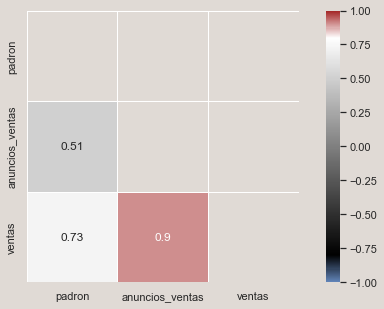

In [480]:
hc = [hex_color(GLAUCUS), '#000', '#fff', hex_color(RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}
fig, ax = plt.subplots(figsize = (10,5), facecolor=rgb(BEIGE))
sns.heatmap(corr, ax=ax, **plot_properties)

In [487]:
np.zeros_like(corr, dtype=int)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
for caso in caso:

<AxesSubplot:xlabel='Periodo'>

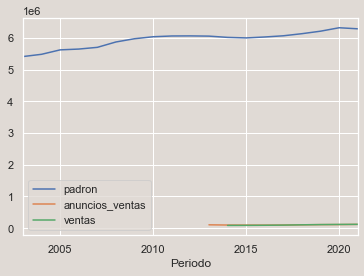

In [474]:
casos[0].plot()

In [488]:
c

,padron,anuncios_ventas,ventas
Periodo,,,
2003-01-01,7860,NaN,NaN
2004-01-01,8594,NaN,NaN
2005-01-01,9301,NaN,NaN
2006-01-01,9824,NaN,NaN
2007-01-01,10316,NaN,NaN
2008-01-01,10890,1703.250000,NaN
2009-01-01,11045,1623.000000,NaN
2010-01-01,11210,1637.833333,NaN
2011-01-01,11545,1570.083333,NaN


In [466]:
for i, c in enumerate(casos):
    if i == 0:
        d = c
    else:
        d += c
d/len(casos)

,padron,anuncios_ventas,ventas
Periodo,,,
2003-01-01,82027.984848,NaN,NaN
2004-01-01,83106.045455,NaN,NaN
2005-01-01,85224.500000,NaN,NaN
2006-01-01,85608.924242,NaN,NaN
2007-01-01,86430.636364,NaN,NaN
2008-01-01,89000.363636,NaN,NaN
2009-01-01,90548.378788,NaN,NaN
2010-01-01,91497.000000,NaN,NaN
2011-01-01,91859.378788,NaN,NaN


In [460]:
d.corr()

,padron,anuncios_renta,anuncios_ventas,ventas
padron,1.000000,NaN,0.926789,0.980140
anuncios_renta,NaN,NaN,NaN,NaN
anuncios_ventas,0.926789,NaN,1.000000,0.964877
ventas,0.980140,NaN,0.964877,1.000000


In [454]:
c

,padron,anuncios_renta,anuncios_ventas,ventas
Periodo,,,,
2003-01-01,15720,NaN,NaN,NaN
2004-01-01,17188,NaN,NaN,NaN
2005-01-01,18602,NaN,NaN,NaN
2006-01-01,19648,NaN,NaN,NaN
2007-01-01,20632,NaN,NaN,NaN
2008-01-01,21780,NaN,3406.500000,NaN
2009-01-01,22090,NaN,3246.000000,NaN
2010-01-01,22420,NaN,3275.666667,NaN
2011-01-01,23090,12.520000,3140.166667,NaN


In [16]:
T = np.zeros(4*4).reshape(4,4)  # Totals
V = np.zeros(4*4).reshape(4,4)  # Variations

for t, v in zip(corr_total, corr_var):
    if t.notna().values.all(): T += t
    if v.notna().values.all(): V += v
T = T/T.iloc[0,0]
V = V/V.iloc[0,0]

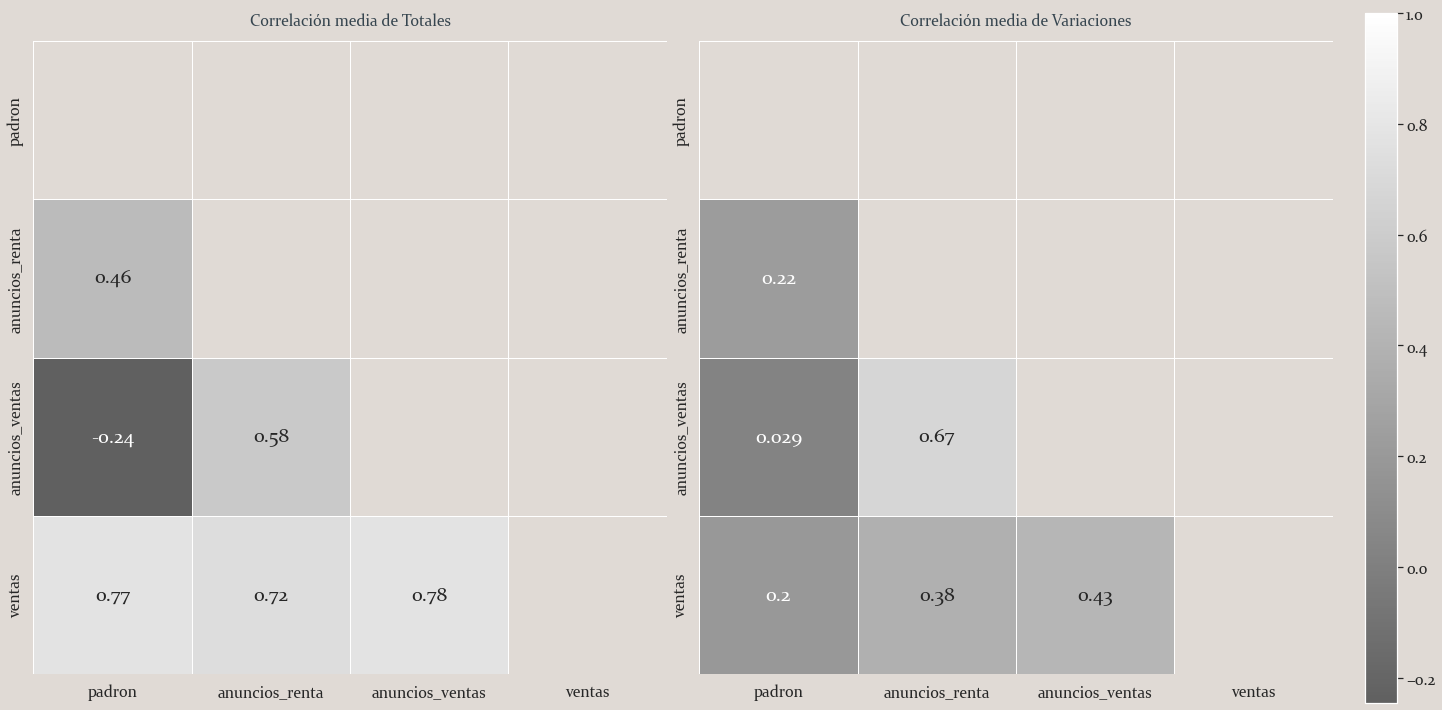

In [22]:
vmin = min(T.values.min(), T.values.min())
vmax = max(V.values.max(), V.values.max())

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(T, dtype=bool))
# Generate a custom colormap
cmap = sns.blend_palette((BLACK,WHITE), as_cmap=True)

sns.set(rc={'axes.facecolor':BEIGE, 'figure.facecolor':BEIGE})

# Set up the matplotlib figure
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw=dict(width_ratios=[2,2,.1]), figsize = (20,10), facecolor=BEIGE)

# Draw the heatmap with the mask and correct aspect ratio
plot_properties = {'cbar':False, 'annot_kws':{"fontsize":20, 'fontname':'Constantia'}, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':vmin,'vmax':vmax,'annot':True,'center':0,'square':True}
sns.heatmap(T, ax=axs[0], **plot_properties)
sns.heatmap(V, ax=axs[1], **plot_properties)

axs[0].set_title('Correlación media de Totales', pad=20, **labelstyle)
axs[1].set_title('Correlación media de Variaciones', pad=20, **labelstyle)

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.tight_layout()
# Change tick styles
for ax in axs:
    for label in ax.get_xticklabels(): label.set_fontproperties(ticks_style)
    for label in ax.get_yticklabels(): label.set_fontproperties(ticks_style)
plt.savefig(f'EDA/plot/Poblacion Precio Venta Alquiler Correlacion Totales y Variaciones.png')
plt.show()
plt.close()

# Transacciones & hipotecas
## Cuántas de las transacciones de vivienda son mediante hipotecas ?

In [35]:
transactions_path = 'data/mitma_transactions.sqlite'
appraisals_path = 'data/mitma_appraisals.sqlite'

con_trans = sqlite3.connect(transactions_path)
con_appr = sqlite3.connect(appraisals_path)

df1 = pd.read_sql_query(f'SELECT * from "1_1_NumeroTransaccionesInmobiliariasViviendaLibre"', con_trans)
df2 = pd.read_sql_query(f'SELECT * from "3_3ValorMedioLasTransaccionesInmobiliariasViviendaLibre"', con_trans)
# dm = pd.read_sql_query(f'SELECT * from PopulationSexCityAge', con_appr)

# ir['datetime'] = pd.to_datetime(ir.datetime)
# ir = ir.groupby(ir.datetime.dt.year).mean()
# ir.index = pd.to_datetime(ir.index, format='%Y')

# iv['datetime'] = pd.to_datetime(iv.datetime)
# iv = iv.groupby(iv.datetime.dt.year).mean()
# iv.index = pd.to_datetime(iv.index, format='%Y')

# dm = dm.loc[(dm.Sexo == 'Total') & (dm['Edad (grupos quinquenales)'] == 'Todas las edades')]
# dm = dm.pivot(index='Periodo', columns='City', values='Total')
# dm.index = pd.to_datetime(dm.index)

In [43]:
def get_all_df(filepath):
    con = sqlite3.connect(filepath)
    tablelist = pd.read_sql_query('SELECT name from sqlite_master where type= "table";', con).name.to_list()
    tabledict = {}

    # Open each table and append it to the dict
    for tablename in tablelist:
        df = pd.read_sql_query(f'SELECT * from "{tablename}"', con)
        # print(df.shape)
        tabledict[tablename] = df
    con.close()
    return tabledict

In [73]:
transactions = get_all_df(transactions_path)

In [439]:
# Reshape the data so I can have a dataframe where all the data is for the same geography
data = {}
# Create a dict of df with the number of transaction by Province
for i, (tablename, dg) in enumerate(transactions.items()):
    print(i, tablename)
    df = dg.copy()
    # First clean the df
    if 'Date' in df.columns:
        df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
        df.index = df.Date
        df = df.drop(columns='Date')
    else:
        # print('cont')
        continue

    # Initialize the data
    if i == 0:
        base_columns = df.columns
        base_len = df.shape[0]
        for col in base_columns:
            data[col] = pd.DataFrame()

    # Append the columns
    for col in base_columns:
        new_name = list(data[col].columns)
        new_name.append(tablename)
        if col in df.columns:
            data[col] = pd.concat([data[col], df[col]], axis=1)
            data[col].columns = new_name
        else:    # The column doesn't exist in the current df 
            # print(i, 'KeyError', col)
            pass
    # break

for tablename, dg in data.items():
    dg.replace('-',math.nan, inplace=True)
    data[tablename] = dg.astype('float')

0 1_NumeroTotalTransaccionesInmobiliariasViviendas
1 1_1_NumeroTransaccionesInmobiliariasViviendaLibre
2 1_1_1_NumeroTransaccionesInmobiliariasViviendaLibreNueva
3 1_1_2_NumeroTransaccionesInmobiliariasViviendaLibredaMano
4 1_2_NumeroTransaccionesInmobiliariasViviendaProtegida_
5 1_2_1_NumeroTransaccionesInmobiliariasViviendaProtegidaNueva
6 1_2_2_NumeroTransaccionesInmobiliariasViviendaProtegidadaMano
7 1_3_NumeroTransaccionesInmobiliariasViviendaNueva
8 1_4_NumeroTransaccionesInmobiliariasViviendadaMano_
9 2_NumeroTotalTransaccionesInmobiliariasViviendasMunicipios
10 2_1_TransaccionesInmobiliariasViviendaLibreMunicipios
11 2_2_TransaccionesInmobiliariasViviendaProtegidaMunicipios
12 2_3_TransaccionesInmobiliariasViviendaNuevaMunicipios
13 2_4_TransaccionesInmobiliariasViviendadaManoMunicipios
14 3_1ValorLasTransaccionesInmobiliariasViviendaLibre
15 3_1_1ValorLasTransaccionesInmobiliariasViviendaLibreNueva
16 3_1_2ValorLasTransaccionesInmobiliariasViviendaLibredaMano
17 3_3ValorMedioL

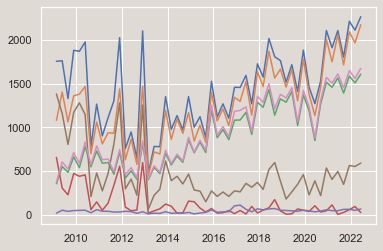

In [132]:
plt.plot(data[province][numbers])

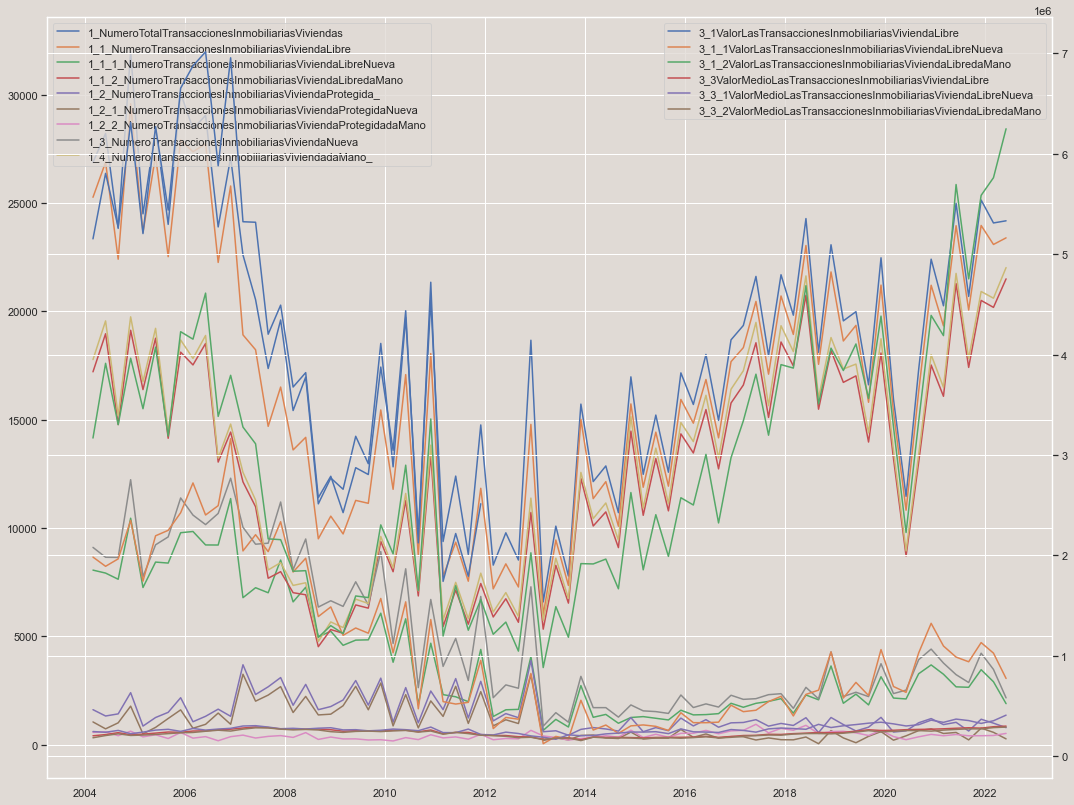

In [153]:
province = 'Madrid_(Comunidad_de)'
numbers = []
values = []

numbers = [col for col in data[province].columns if 'Numero' in col]
values = [col for col in data[province].columns if 'Valor' in col]


fig, ax = plt.subplots(figsize = (18,14), facecolor=BEIGE)
axr = ax.twinx()
# axr.spines.right.set_position(("axes", 1.05))

ax.plot(data[province][numbers], label=numbers)
axr.plot(data[province][values], label=values)

ax.legend(loc='upper left')
axr.legend(loc='upper right')
plt.show()
plt.close()
# data['Asturias_(Principado_de)'].astype('float').plot()

In [285]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict


ordered_columns = data[province].corr().sum().sort_values(ascending=False).index.values
corr = data[province][ordered_columns].corr()

# np.fill_diagonal(corr.values, math.nan)
# corr['row'] = corr.apply(lambda x: x.sum(), axis=1)
# corr.sort_values(by='row', inplace=True, ascending=False)
# corr.drop(columns='row',inplace=True)
# corr.sort_index(level=corr.columns, axis=0, inplace=True)

<AxesSubplot:>

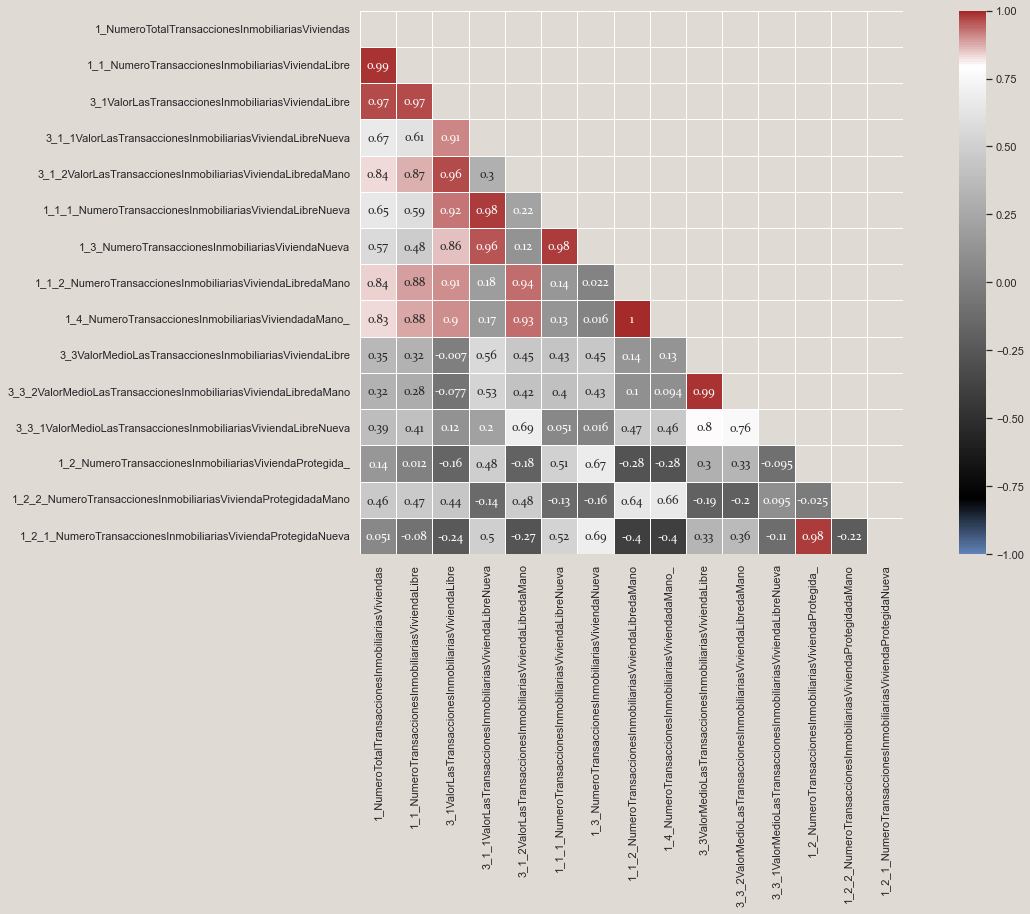

In [286]:
hc = [hex_color(GLAUCUS), '#000', '#fff', hex_color(RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom colormap
# cmap = sns.blend_palette((rgb(BLACK),rgb(WHITE)), as_cmap=True)

plot_properties = {'cbar':True, 'annot_kws':{"fontsize":12, 'fontname':'Constantia'}, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':True,'center':0,'square':True}
fig, ax = plt.subplots(figsize = (20,10), facecolor=rgb(BEIGE))
sns.heatmap(corr, ax=ax, **plot_properties)

# Add appraisals

In [294]:
appraisals_path = 'data/mitma_appraisals.sqlite'

In [440]:
# data = {}
appraisals = get_all_df(appraisals_path)
# Create a dict of df with the appraisals data by Province
for i, (tablename, dg) in enumerate(appraisals.items()):
    print(i, tablename)
    df = dg.copy()
    # First clean the df
    if 'Date' in df.columns:
        df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
        df.index = df.Date
        df = df.drop(columns='Date')
    else:
        # print('cont')
        continue

    # Initialize the data
    # if i == 0:
    #     base_columns = df.columns
    #     base_len = df.shape[0]
    #     for col in base_columns:
    #         data[col] = pd.DataFrame()

    # Append the columns
    for col in base_columns:
        new_name = list(data[col].columns)
        new_name.append(tablename)
        if col in df.columns:
            data[col] = pd.concat([data[col], df[col]], axis=1)
            data[col].columns = new_name
            data[col].replace('-',math.nan, inplace=True)
            data[col].replace('º',math.nan, inplace=True)
            data[col] = data[col].astype('float')
        else:    # The column doesn't exist in the current df 
            # print(i, 'KeyError', col)
            pass
    # break

0 1_ValorTasadoViviendaLibre
1 1_1_ValorTasadoViviendaLibreHastaCincoAnosAntiguedad
2 1_2_ValorTasadoViviendaLibreConMasCincoAnosAntiguedad
3 2_ValorTasadoViviendaProtegida
4 3_Tasaciones
5 4_Municipios25000_ValorTasadoViviendaHasta5Anos
6 4_Municipios25000_ValorTasadoViviendaMasDe5Anos
7 4_Municipios25000_ValorTasadoViviendaTotal
8 4_Municipios25000_NumTasacionesViviendaHasta5Anos
9 4_Municipios25000_NumTasacionesViviendaMasDe5Anos
10 4_Municipios25000_NumTasacionesViviendaTotal
11 7_2_1TasacionesViviendaTipologia_ViviendasProyectoConstruccion_FinalidadHipotecaria_Total
12 7_2_1TasacionesViviendaTipologia_ViviendasProyectoConstruccion_FinalidadHipotecaria_ViviendaUnifamiliarAislada
13 7_2_1TasacionesViviendaTipologia_ViviendasProyectoConstruccion_FinalidadHipotecaria_ViviendaUnifamiliarAdosada
14 7_2_1TasacionesViviendaTipologia_ViviendasProyectoConstruccion_FinalidadHipotecaria_ViviendaEnBloque
15 7_2_1TasacionesViviendaTipologia_ViviendasProyectoConstruccion_FinalidadHipotecaria_NoC

In [441]:
data['TOTAL_NACIONAL'].columns

Index(['1_NumeroTotalTransaccionesInmobiliariasViviendas',
       '1_1_NumeroTransaccionesInmobiliariasViviendaLibre',
       '1_1_1_NumeroTransaccionesInmobiliariasViviendaLibreNueva',
       '1_1_2_NumeroTransaccionesInmobiliariasViviendaLibredaMano',
       '1_2_NumeroTransaccionesInmobiliariasViviendaProtegida_',
       '1_2_1_NumeroTransaccionesInmobiliariasViviendaProtegidaNueva',
       '1_2_2_NumeroTransaccionesInmobiliariasViviendaProtegidadaMano',
       '1_3_NumeroTransaccionesInmobiliariasViviendaNueva',
       '1_4_NumeroTransaccionesInmobiliariasViviendadaMano_',
       '3_1ValorLasTransaccionesInmobiliariasViviendaLibre',
       ...
       '10_TasacionesViviendaAntiguedad_ViviendasTerminadas_NoConsta',
       '10_1TasacionesViviendaAntiguedad_ViviendasTerminadas_FinalidadHipotecaria_Total',
       '10_1TasacionesViviendaAntiguedad_ViviendasTerminadas_FinalidadHipotecaria_IgualOMenorDe5Anos',
       '10_1TasacionesViviendaAntiguedad_ViviendasTerminadas_FinalidadHipotecari

In [442]:
ordered_columns = data[province].corr().sum().sort_values(ascending=False).index.values
corr = data[province][ordered_columns].corr()

hc = [hex_color(GLAUCUS), '#000', '#fff', hex_color(RED)]
th = [0, 0.1, 0.9, 1]
cdict = NonLinCdict(th, hc)
cmap = LinearSegmentedColormap('test', cdict)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom colormap
# cmap = sns.blend_palette((rgb(BLACK),rgb(WHITE)), as_cmap=True)

<AxesSubplot:>

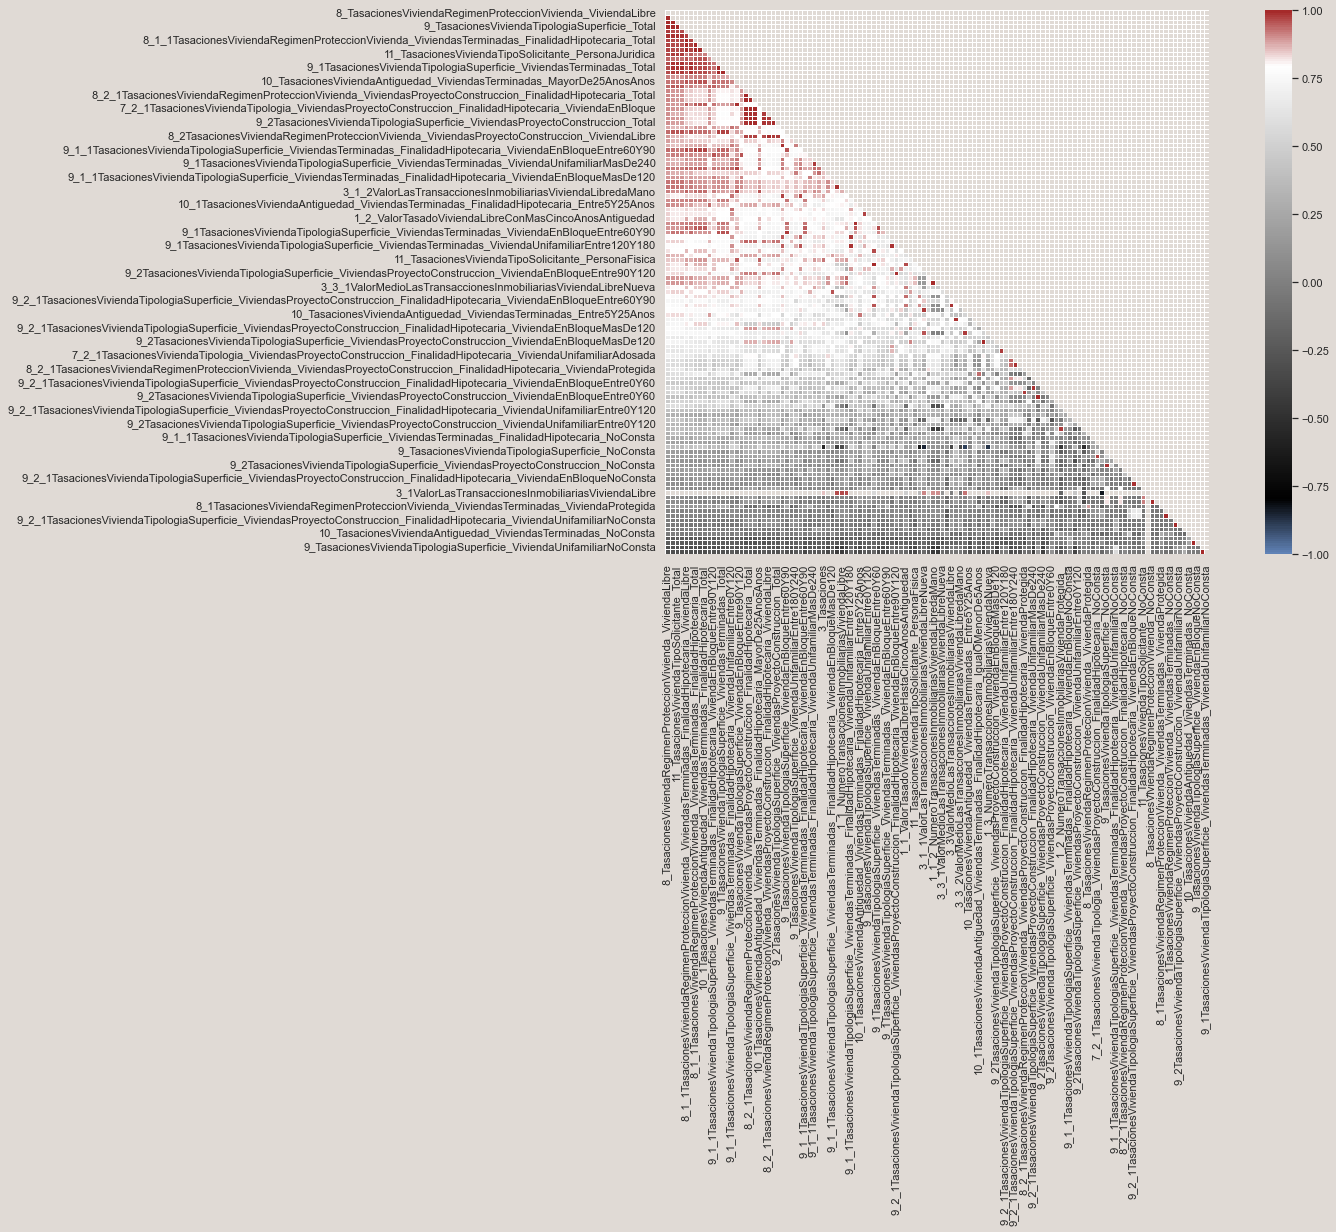

In [443]:
plot_properties = {'cbar':True, 'linewidths':.5,'mask':mask,'cmap':cmap,'vmin':-1,'vmax':1,'annot':False,'center':0,'square':True}
fig, ax = plt.subplots(figsize = (20,10), facecolor=rgb(BEIGE))
sns.heatmap(corr, ax=ax, **plot_properties)

In [446]:
fig.savefig(f'EDA/plot/Tasaciones y Transacciones - {province}.png')

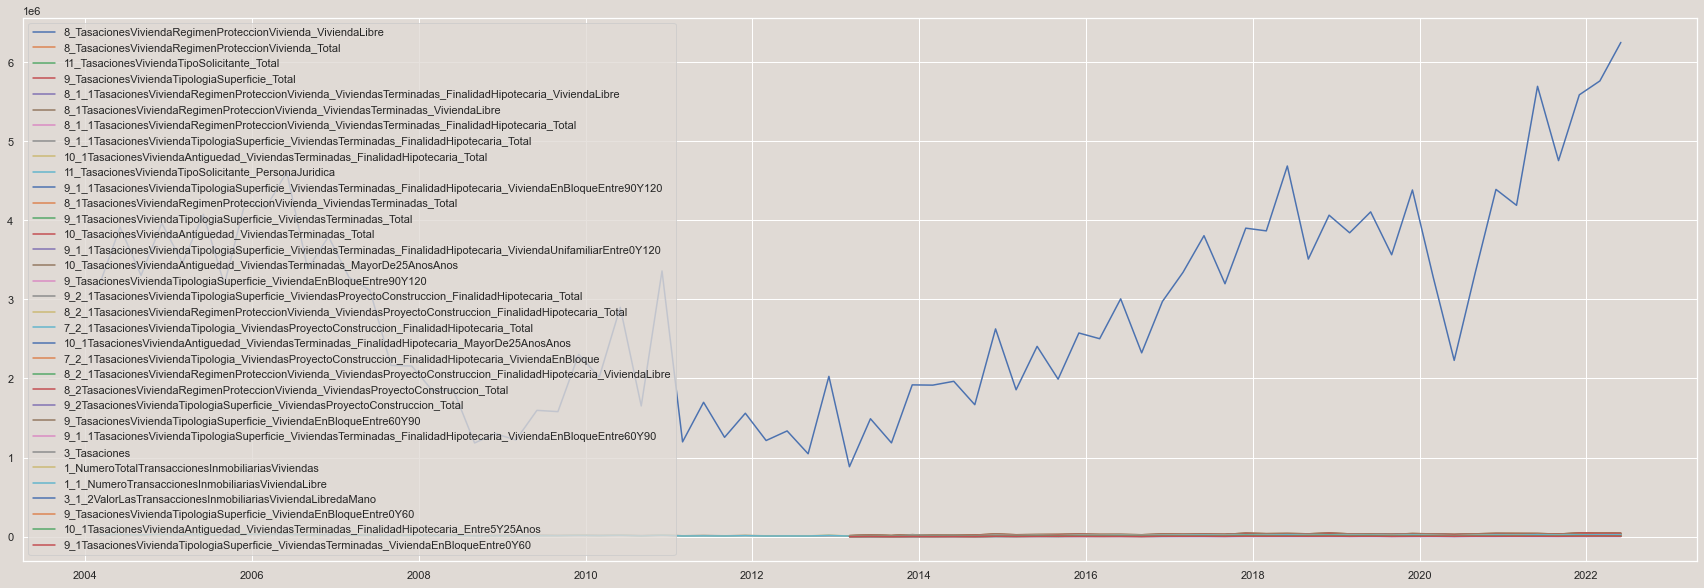

In [447]:
high_correlation_columns = corr[corr.iloc[0]>.9].index

fig, ax = plt.subplots(figsize=(30,10), facecolor=rgb(BEIGE))

ax.plot(data[province][high_correlation_columns], label = high_correlation_columns)
ax.legend(loc='upper left')

# Finanzas

In [494]:
importlib.reload(dp)

<module 'data_processing' from 'e:\\1C Cursos\\Data Science Part Time - The Bridge\\DS\\Proyecto\\data_processing.py'>

In [497]:
finance_path = 'data/finance.sqlite'
finance_series = dp.get_df(finance_path, 'Fact')

In [501]:
monthly_data_series = finance_series[finance_series.Frequency == 'MENSUAL'].TableName.unique()

array(['be1901', 'be1902', 'be1903', 'be1904', 'be1905', 'be1906',
       'be1907', 'be1908', 'be1909', 'be1910', 'be1911', 'be1912',
       'be1913', 'be1914', 'be1915', 'be1916', 'be1917', 'be0115',
       'be0210', 'be2631', 'be2632', 'si_3_1', 'be2116', 'be2633',
       'be2634', 'be2635', 'be2636', 'be0208', 'si_1_3', 'be0316',
       'be0317', 'be0318', 'be0319', 'be0320', 'be0321', 'be0322',
       'be11a', 'be11b', 'be12a', 'be12b', 'be12c', 'be13a', 'be1116',
       'be1701', 'be1702', 'be172a', 'be1703', 'be1708', 'be1712',
       'be1707', 'be1726', 'be1725', 'be2110', 'be2103', 'be2104',
       'be2105', 'be2106', 'be2107', 'be2108', 'be2109', 'be2111',
       'be2112', 'be2115', 'be2117', 'be2118', 'be2119', 'be2120',
       'be2122', 'be2123', 'be2121', 'be2101', 'be2102', 'be2203',
       'be2204', 'be2231', 'be2232', 'be2205', 'be2206', 'be2207',
       'be2208', 'be2222', 'si_1_3a', 'be2223', 'be2224', 'be2226',
       'be2225', 'be2227', 'be2228', 'be2229', 'be2230', 